# Importing Packages

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# this line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10


# COVID-19 Data preprocessing

## we will use the data regarding the diagnosis of covid 19 gathered by the Israeli Ministry of Health: https://data.gov.il/dataset/covid-19

In [29]:
dataset = pd.read_csv("data/corona_tests.csv")
dataset

/home/nirlalum/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,age_60_and_above,gender,corona_result
0,2020-04-30,0,0,0,0,0,Other,None,female,negative
1,2020-04-30,1,0,0,0,0,Other,None,female,negative
2,2020-04-30,0,1,0,0,0,Other,None,male,negative
3,2020-04-30,1,0,0,0,0,Other,None,female,negative
4,2020-04-30,1,0,0,0,0,Other,None,male,negative
...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,Other,None,None,negative
278844,2020-03-11,0,0,0,0,0,Other,None,None,negative
278845,2020-03-11,0,0,0,0,0,Contact with confirmed,None,None,positive
278846,2020-03-11,0,0,0,0,0,Other,None,None,other


## EDA

In [30]:
dataset.head()


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,age_60_and_above,gender,corona_result
0,2020-04-30,0,0,0,0,0,Other,None,female,negative
1,2020-04-30,1,0,0,0,0,Other,None,female,negative
2,2020-04-30,0,1,0,0,0,Other,None,male,negative
3,2020-04-30,1,0,0,0,0,Other,None,female,negative
4,2020-04-30,1,0,0,0,0,Other,None,male,negative


In [31]:
# check for null values
dataset.isnull().sum()

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
test_indication        0
age_60_and_above       0
gender                 0
corona_result          0
dtype: int64

In [32]:
# this function checks the values count and type of all the columns of a dataframe
def check_values_count(data): 
    for column in data:
        if column == 'test_date':
            continue
        count = data[column].value_counts()
        print(f"the different values for {column}:\n {count} \n")

check_values_count(dataset)






the different values for cough:
 0       121649
0       114719
1        25875
1        16353
None       252
Name: cough, dtype: int64 

the different values for fever:
 0       133942
0       122902
1        13582
1         8170
None       252
Name: fever, dtype: int64 

the different values for sore_throat:
 0       260664
0        16257
1         1480
1          446
None         1
Name: sore_throat, dtype: int64 

the different values for shortness_of_breath:
 0       261079
0        16191
1         1065
1          512
None         1
Name: shortness_of_breath, dtype: int64 

the different values for head_ache:
 0       260079
0        16354
1         2065
1          349
None         1
Name: head_ache, dtype: int64 

the different values for test_indication:
 Other                     242741
Abroad                     25468
Contact with confirmed     10639
Name: test_indication, dtype: int64 

the different values for age_60_and_above:
 None    127320
No      125703
Yes      25825
Nam

### Conclusion: As we can see there are no null values but there are None values. we will deal with that later.
### Now we will check distributions of the data


### First we will check distribution of the diagnosis:

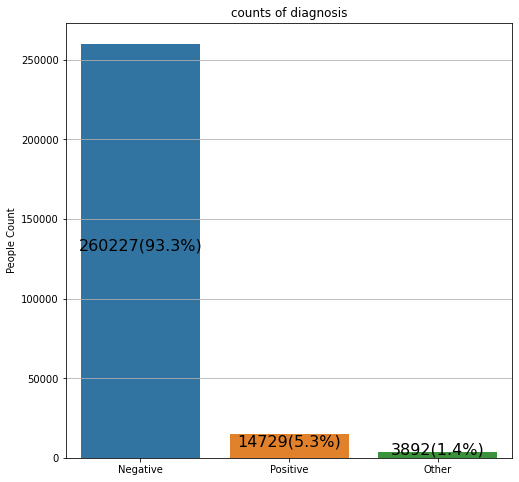

In [33]:
figure, diagnosis_bar = plt.subplots()
sns.barplot(x = dataset['corona_result'].value_counts().index, y = dataset['corona_result'].value_counts(), ax = diagnosis_bar)
diagnosis_bar.set_xticklabels(['Negative', 'Positive', 'Other'])
diagnosis_bar.set_ylabel('People Count')
diagnosis_bar.set_title('counts of diagnosis')

for patch in diagnosis_bar.patches:
    x_label = patch.get_x() + patch.get_width()/2
    y_label = patch.get_y() + patch.get_height()/2
    diagnosis_bar.text(x_label, y_label, str(int(patch.get_height())) + '(' +  '{:.1%}'.format(patch.get_height()/len(dataset['corona_result'])) + ')',
    horizontalalignment='center', verticalalignment='baseline', fontsize = 16)


### We can see that the data is imbalanced.
### Now we check the distributions of the different features and check how they influence the diagnosis (while we ignore None values, we will check the
### distributions again after data imputation).
### The distributions displayed here describe Pr(pisitive|some feature)

100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


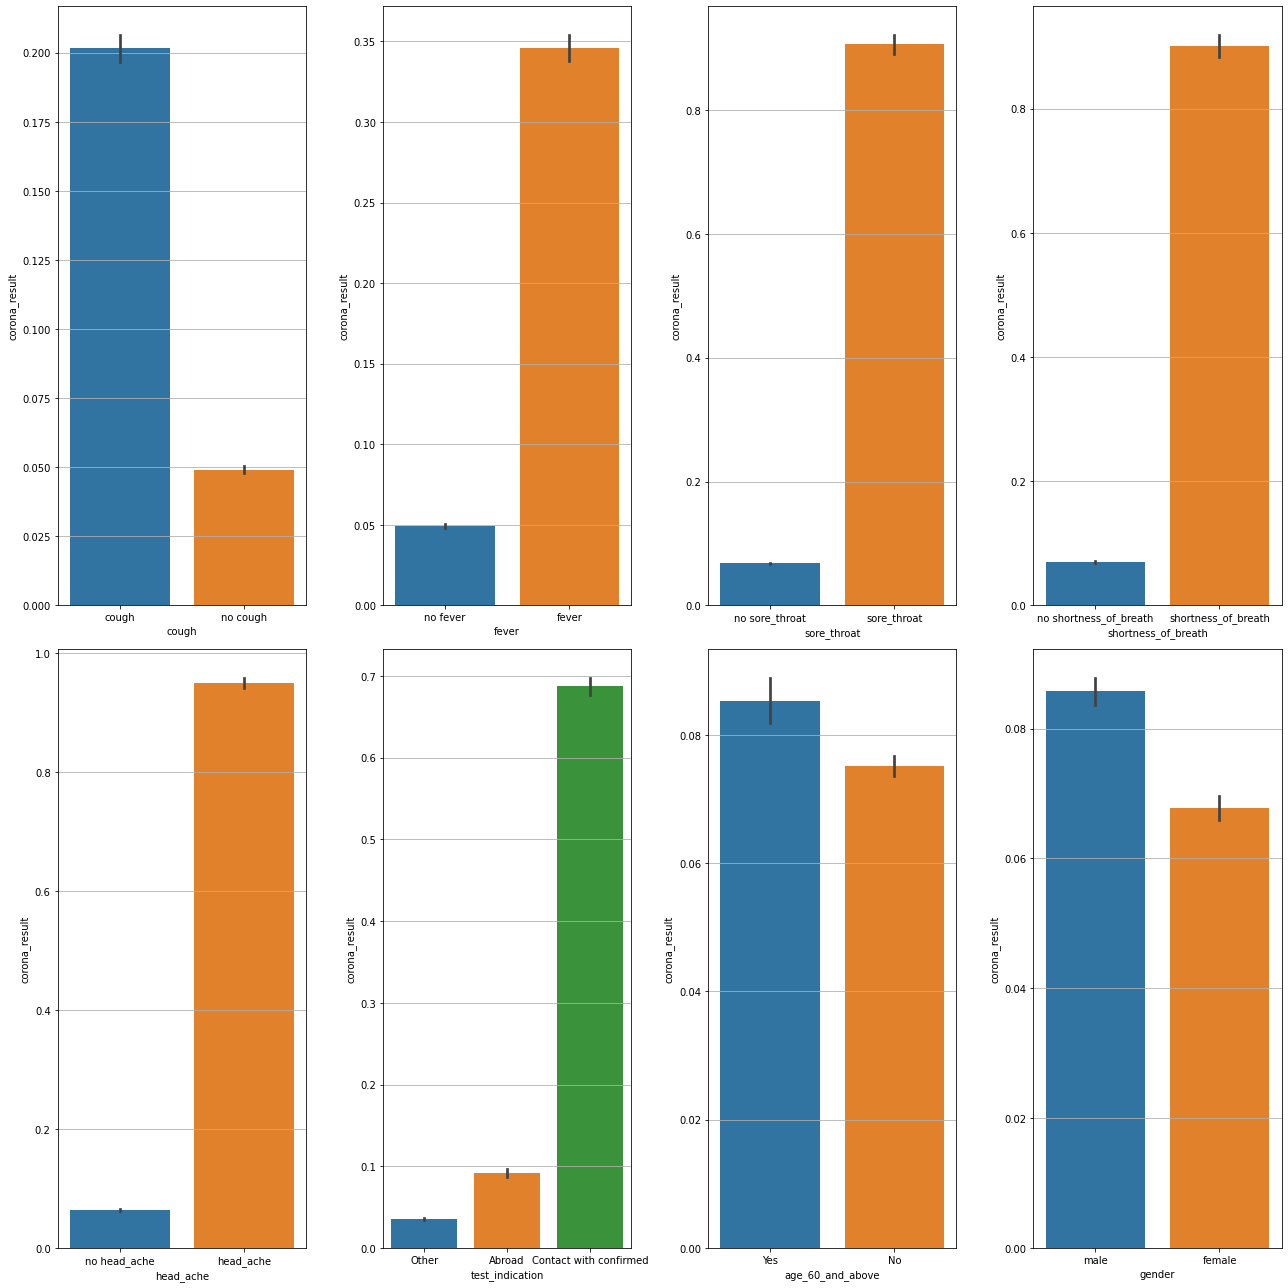

In [94]:
# this function maps values for given dataset, column name and dictionary
# dict_costum is a boolean: True - dict is given from user else default dict 
def map_columns(data, column, dict_costum = False , map_dict = None):
    if dict_costum:
        data[column] = data[column].map(map_dict)
    else:
        dict_def = {0 : 'no' + ' ' + column, 1 : column}
        data[column] = data[column].map(dict_def)


columns_list = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']

# ignore rows with None values (just for now - later we will do imputing)
data_plot = dataset.copy(deep=True)
for column in data_plot.columns:
    indexNames = data_plot[data_plot[column]=='None'].index
    data_plot.drop(indexNames, inplace=True)

#check_values_count(data_plot) # check if the data is cleaned

# cast the data to int
for column in columns_list[0:5]:
    data_plot[column] = data_plot[column].astype('str').astype('int')       

for column in columns_list:
    if column == 'corona_result':
        corona_result_dict = {'positive' : 1, 'negative' : 0, 'other' : 0} # should pther be 0 or 1 or maybe deleted
        map_columns(data_plot, column, dict_costum = True, map_dict = corona_result_dict)
    else:
        map_columns(data_plot, column)
    
#check_values_count(data_plot) # check if the data is mapped

# plot histograms of the different features
fig, axs = plt.subplots(2, 4, figsize = (18.0, 18.0))
i, j = (0, 0)
for column in tqdm(dataset.columns):
    if column == 'test_date' or column == 'corona_result':
        continue
    
    ax = axs[i,j]
    sns.barplot(x = column, y = 'corona_result', data=data_plot, ax = ax)
    
    if j == 3:
        i = i + 1
        j = 0
        continue
    
    j = j + 1

fig.tight_layout()

